(dry_mixed_layer)=
# dry mixed layer model

see the [mixed layer notes](https://www.dropbox.com/scl/fi/8l9qb7mqtfhs58b4s7jf6/mixed_layer.pdf?rlkey=a2av8cmvjvvti44723hn69acw&dl=0) equations 11-13

$$
\begin{align}
  \text{mean temperature: } \frac{d \hat{\theta} }{dt} &=(1 + k) F_0/(h c_p\rho_*)\label{eq:meantheta}\\
\text{inversion height: } \frac{dh }{dt} &= ( k F_0)/(\rho_* c_p \Delta \theta) + w_h \label{eq:hrise}\\
\text{inversion jump: } \frac{d \Delta \theta }{dt} &= \left ( \frac{dh }{dt}  - w_h \right ) \Gamma - \frac{d \hat{\theta} }{dt}\label{eq:jump}
\end{align}
$$



/Users/phil/mini310/envs/a405/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/Users/phil/mini310/envs/a405/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


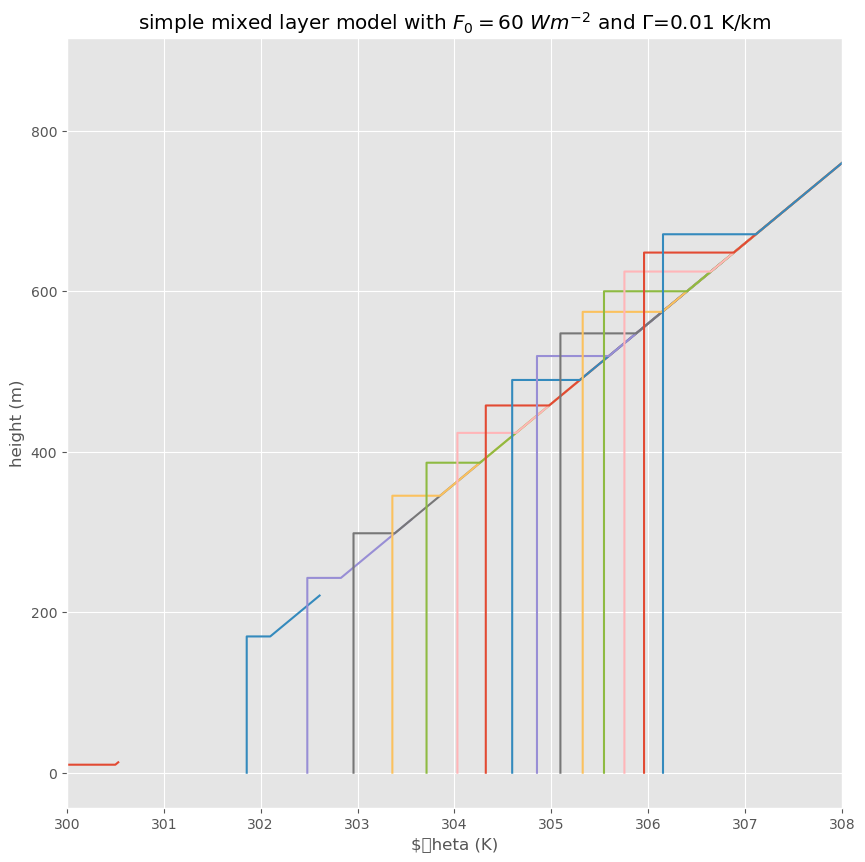

In [1]:
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd


def dmixed_vars(the_vars,tstep,F0,wh,gamma):
    """
      derivatives for simple mixed layer (see mixed layer notes eqn. 11-13)
    """
    k=0.2
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(1 + k)*F0/(the_vars[1]*cp*rho)
    derivs[1] = k*F0/(rho*cp*the_vars[2]) + wh
    derivs[2] = (derivs[1] - wh)*gamma - derivs[0]
    return derivs

def make_prof(df_out,gamma):
    #
    #  construct a vertical (theta, height) profile with the correct Delta theta jump
    #  using four points. The final point is at a height that is in the inversion at 1.3h (arbitrary)
    #
    profile=[(df_out['theta'],0),
             (df_out['theta'],df_out['h']),
             (df_out['theta'] + df_out['deltheta'],df_out['h']),
             (df_out['theta'] + df_out['deltheta'] + gamma*0.3*df_out['h'],1.3*df_out['h'])]
    xvals=[item[0] for item in profile]
    yvals=[item[1] for item in profile]
    return xvals,yvals

dtout=10.  #minutes
tf=8   #hours
dtout=dtout*60.
tf=tf*3600.
tspan = np.arange(0.,tf,dtout)
vars_init=[300.,10,0.5]  #theta (K), height (m), del theta (K) to start
gamma=10.e-3  #K/m
F0 = 60 #W/m^2
wh= 0.  #m/s
output=integrate.odeint(dmixed_vars, vars_init, tspan,(F0,wh,gamma))
result=pd.DataFrame.from_records(output,columns=['theta','h','deltheta'])
result['time']=tspan
out=result.to_dict(orient='records')

plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,1,figsize=(10,10))
for count,row in enumerate(out):
    if np.mod(count,3) == 0:
        thetavals,heightvals=make_prof(row,gamma)
        ax.plot(thetavals,heightvals)
#
# note that the title tuple concatenates the two lines together if
# the aren't separated by a comma
#
out=ax.set(xlim=(300,308),xlabel='$\theta (K)',ylabel='height (m)',
          title=(f'simple mixed layer model with '
                 f'$F_0 = {F0}\ Wm^{{-2}}$ and $\Gamma$={gamma} K/km'))

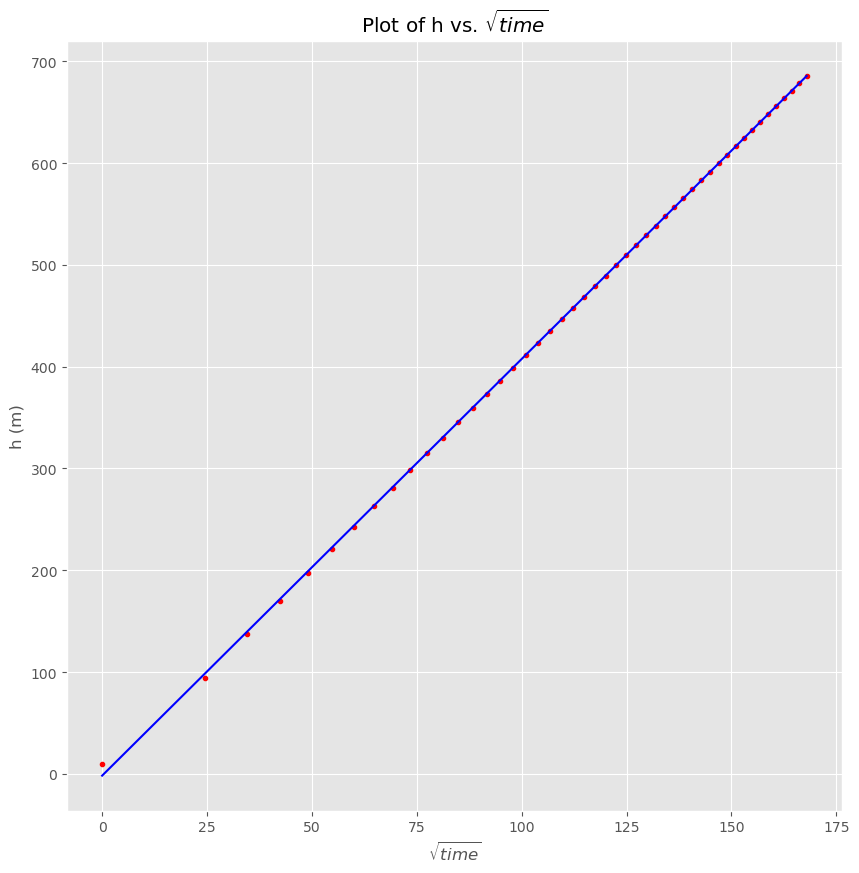

In [2]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(np.sqrt(result.time), result.h, 'r.')
p = np.polyfit(np.sqrt(result.time),result.h,1)
fit_h = np.polyval(p,np.sqrt(result.time))
ax.plot(np.sqrt(result.time),fit_h,'-b')
ax.set(title=r"Plot of h vs. $\sqrt{time}$", xlabel=r"$\sqrt{time}$", ylabel=r"h (m)");

## find value of k ($\beta$ in Garratt)

Do a sanity check using Garratt -- we should get back a value if $\beta$ = $k$ = 0.2 when we integrate dh/dt to get h(t)

Garratt (6.18): $$\frac{dh} {dt} = \frac {(1+2\beta)\overline{w'\theta_v'}_0} {\gamma_\theta h}$$

Integrate: $$\int{h dh} = \int \frac {(1+2\beta)\overline{w'\theta_v'}_0} {\gamma_\theta} dt$$

$$h = \sqrt \frac {2(1+2\beta)\overline{w'\theta_v'}_0} {\gamma_\theta}t + C$$

Apply linear regression, so slope of the line is: $$m = \sqrt \frac {2(1+2\beta)\overline{w'\theta_v'}_0} {\gamma_\theta}$$

Then: $$\beta = 1/2(\frac{m^2 \gamma_\theta} {2 \overline{w'\theta_v'}_0} - 1) = 1/2(\frac{m^2 \gamma_\theta \rho c_p} {2 F_o} - 1) $$

In [3]:
slope = p[0]
rho=1.
cp=1004.
F0 = 60 #W/m^2
beta = 0.5*(slope**2*gamma/(2*F0/(rho*cp))-1)
print(f"{beta=:.3f}")

beta=0.201
